## Import Library

In [5]:
import pandas as pd
pd.set_option("display.max_column", 100)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import  silhouette_score
from sklearn.cluster import KMeans


# Datetime module
from datetime import datetime, date, timedelta

In [6]:
from yellowbrick.cluster import KElbowVisualizer

# 1. Salesdata

## 1. Import Salesdata

In [7]:
# Dataset = Salesdata.csv

df = pd.read_csv("Salesdata.csv")
df.head()

,SalesOrderLineKey,ResellerKey,CustomerKey,SALE ORDER,ProductKey,OrderDateKey,ORDER DATE,DueDateKey,ShipDateKey,SalesTerritoryKey,Order Quantity,Unit Price,Extended Amount,Unit Price Discount Pct,Product Standard Cost,Total Product Cost,Sales Amount
0,43793001,-1,11000,SO43793,344,20170712,12/07/2017,20170722,20170719.0,9,1,3399.99,3399.99,0,1912.1544,1912.1544,3399.99
1,51522001,-1,11000,SO51522,353,20190621,21/06/2019,20190701,20190628.0,9,1,2319.99,2319.99,0,1265.6195,1265.6195,2319.99
2,51522002,-1,11000,SO51522,485,20190621,21/06/2019,20190701,20190628.0,9,1,21.98,21.98,0,8.2205,8.2205,21.98
3,57418001,-1,11000,SO57418,573,20191004,04/10/2019,20191014,20191011.0,9,1,2384.07,2384.07,0,1481.9379,1481.9379,2384.07
4,57418002,-1,11000,SO57418,541,20191004,04/10/2019,20191014,20191011.0,9,1,28.99,28.99,0,10.8423,10.8423,28.99


## 2. Data cleaning Salesdata

In [8]:
# Get the list of columns

df.columns

Index(['SalesOrderLineKey', 'ResellerKey', 'CustomerKey', 'SALE ORDER',
       'ProductKey', 'OrderDateKey', 'ORDER DATE', 'DueDateKey', 'ShipDateKey',
       'SalesTerritoryKey', 'Order Quantity', 'Unit Price', 'Extended Amount',
       'Unit Price Discount Pct', 'Product Standard Cost',
       'Total Product Cost', 'Sales Amount'],
      dtype='object')

In [9]:
# Drop unnecessary columns

df = df[['CustomerKey','SALE ORDER','ORDER DATE', 'Sales Amount']].copy()
df.head()

,CustomerKey,SALE ORDER,ORDER DATE,Sales Amount
0,11000,SO43793,12/07/2017,3399.99
1,11000,SO51522,21/06/2019,2319.99
2,11000,SO51522,21/06/2019,21.98
3,11000,SO57418,04/10/2019,2384.07
4,11000,SO57418,04/10/2019,28.99


In [10]:
# Check the data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CustomerKey   60398 non-null  int64  
 1   SALE ORDER    60398 non-null  object 
 2   ORDER DATE    60398 non-null  object 
 3   Sales Amount  60398 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.8+ MB


In [11]:
# Change OrderDate column dtype to datetime

df['ORDER DATE'] = pd.to_datetime(df['ORDER DATE'], format="%d/%m/%Y")

# check the data info again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CustomerKey   60398 non-null  int64         
 1   SALE ORDER    60398 non-null  object        
 2   ORDER DATE    60398 non-null  datetime64[ns]
 3   Sales Amount  60398 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.8+ MB


In [12]:
# Checking if the OrderDate column data match the format by returning the min and max of day/month/year

# Check the day column
day_date = df['ORDER DATE'].dt.day
print("day_min: %i" %day_date.min())
print("day_max: %i \n" %day_date.max())

# Check the month column
month_date = df['ORDER DATE'].dt.month
print("month_min: %i" %month_date.min())
print("month_max: %i \n" %month_date.max())

# Check the month column
year_date = df['ORDER DATE'].dt.year
print("year_min: %i" %year_date.min())
print("year_max: %i \n" %year_date.max())

day_min: 1
day_max: 31 

month_min: 1
month_max: 12 

year_min: 2017
year_max: 2020 



In [13]:
# Change column name

# the column name is already pretty good, but I prefer use lowercase and use underscore instead of space, 
# for me, it's easier to read

df.rename(columns={'CustomerKey':'customer_key','SALE ORDER':'sales_order_number',
         'ORDER DATE':'order_date', 'Sales Amount':'sales_amount'}, inplace = True) 
df.head()

,customer_key,sales_order_number,order_date,sales_amount
0,11000,SO43793,2017-07-12,3399.99
1,11000,SO51522,2019-06-21,2319.99
2,11000,SO51522,2019-06-21,21.98
3,11000,SO57418,2019-10-04,2384.07
4,11000,SO57418,2019-10-04,28.99


In [14]:
# Check point

df_copy = df.copy()
# df = df_copy

## 3. Creating RFM Table

In [15]:
# We need to group the rfm by the customer, sales order number, order date to remove duplicates
# and sum the sales amount

df = df.groupby(['customer_key','sales_order_number','order_date']).sales_amount.sum()
df.head()

customer_key  sales_order_number  order_date
11000         SO43793             2017-07-12    3399.99
              SO51522             2019-06-21    2341.97
              SO57418             2019-10-04    2507.03
11001         SO43767             2017-07-09    3374.99
              SO51493             2019-06-19    2419.93
Name: sales_amount, dtype: float64

In [16]:
# Reset index

df = df.reset_index()
df.head(10)

,customer_key,sales_order_number,order_date,sales_amount
0,11000,SO43793,2017-07-12,3399.99
1,11000,SO51522,2019-06-21,2341.97
2,11000,SO57418,2019-10-04,2507.03
3,11001,SO43767,2017-07-09,3374.99
4,11001,SO51493,2019-06-19,2419.93
5,11001,SO72773,2020-05-12,588.96
6,11002,SO43736,2017-07-05,3399.99
7,11002,SO51238,2019-06-03,2294.99
8,11002,SO53237,2019-07-27,2419.06
9,11003,SO43701,2017-07-01,3399.99


In [17]:
# Recency Table

# I decided to add 1 day to prevent ambigous analysis/calculation in further step
# example = df.recency.min() = 0 will become 1

daydiff = (df.order_date.max()) - df.groupby('customer_key').order_date.max()
recency = daydiff.dt.days
recency = recency.reset_index()
recency = pd.DataFrame(recency)

recency = recency.rename(columns={'order_date':'recency'})
recency.head()

,customer_key,recency
0,11000,255
1,11001,34
2,11002,324
3,11003,248
4,11004,257


In [18]:
# Frequency Table

freq = df.groupby('customer_key').sales_order_number.count().reset_index()
freq = freq.rename(columns = {'sales_order_number':'frequency'})
freq.head(20)


,customer_key,frequency
0,11000,3
1,11001,3
2,11002,3
3,11003,3
4,11004,3
5,11005,3
6,11006,3
7,11007,3
8,11008,3
9,11009,3


In [19]:
# Monetary Table

monetary = df.groupby('customer_key').sales_amount.sum().reset_index()
monetary = monetary.rename(columns = {'sales_amount':'monetary'})
monetary.head()

,customer_key,monetary
0,11000,8248.99
1,11001,6383.88
2,11002,8114.04
3,11003,8139.29
4,11004,8196.01


In [20]:
# Merge R, F, M Table into 1 DataFrame

rfm = pd.merge(recency, freq, on = 'customer_key',how = 'inner')
rfm = pd.merge(rfm, monetary, on = 'customer_key',how = 'inner')
rfm.head()

,customer_key,recency,frequency,monetary
0,11000,255,3,8248.99
1,11001,34,3,6383.88
2,11002,324,3,8114.04
3,11003,248,3,8139.29
4,11004,257,3,8196.01


In [21]:
rfm.describe()

,customer_key,recency,frequency,monetary
count,18484.000000,18484.000000,18484.000000,18484.000000
mean,20241.500000,174.667983,1.496375,1588.329216
std,5336.015523,145.644062,1.101139,2124.231717
min,11000.000000,0.000000,1.000000,2.290000
25%,15620.750000,71.000000,1.000000,49.970000
50%,20241.500000,153.000000,1.000000,270.265000
75%,24862.250000,248.000000,2.000000,2511.275000
max,29483.000000,1080.000000,28.000000,13295.380000


## 4. RFM-G


In [22]:
#Read Customerdata
df1 = pd.read_csv('Customerdata.csv')
df1.head()

,CustomerKey,Customer ID,Customer,City,State-Province,Country-Region,Postal Code
0,11000,AW00011000,Jon Yang,Rockhampton,Queensland,Australia,4700
1,11001,AW00011001,Eugene Huang,Seaford,Victoria,Australia,3198
2,11002,AW00011002,Ruben Torres,Hobart,Tasmania,Australia,7001
3,11003,AW00011003,Christy Zhu,North Ryde,New South Wales,Australia,2113
4,11004,AW00011004,Elizabeth Johnson,Wollongong,New South Wales,Australia,2500


# Data cleaning

In [23]:
# Get the list of columns

df1.columns

Index(['CustomerKey', 'Customer ID', 'Customer', 'City', 'State-Province',
       'Country-Region', 'Postal Code'],
      dtype='object')

In [24]:
# Drop unnecessary columns

df1 = df1[['CustomerKey','Country-Region']].copy()
df1.head()

,CustomerKey,Country-Region
0,11000,Australia
1,11001,Australia
2,11002,Australia
3,11003,Australia
4,11004,Australia


In [25]:
# Check the data info

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18484 entries, 0 to 18483
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerKey     18484 non-null  int64 
 1   Country-Region  18484 non-null  object
dtypes: int64(1), object(1)
memory usage: 288.9+ KB


In [26]:
# Change column name

# the column name is already pretty good, but I prefer use lowercase and use underscore instead of space, 
# for me, it's easier to read

df1.rename(columns={'CustomerKey':'customer_key','Country-Region':'country_region'}, inplace = True) 
df1.head()

,customer_key,country_region
0,11000,Australia
1,11001,Australia
2,11002,Australia
3,11003,Australia
4,11004,Australia


In [27]:
# Check point

df1_copy = df1.copy()
# df = df_copy

# Table G

In [28]:
geography = df1.merge(monetary, on = 'customer_key',how = 'inner')
geography.head()

,customer_key,country_region,monetary
0,11000,Australia,8248.99
1,11001,Australia,6383.88
2,11002,Australia,8114.04
3,11003,Australia,8139.29
4,11004,Australia,8196.01


In [29]:
sum_geography = geography.groupby('country_region').monetary.sum().reset_index()
sum_geography['sum_sales_of_country']=sum_geography['monetary'].astype(int)
sum_geography.drop('monetary', axis='columns', inplace=True)
sum_geography

,country_region,sum_sales_of_country
0,Australia,9061000
1,Canada,1977844
2,France,2644017
3,Germany,2894312
4,United Kingdom,3391712
5,United States,9389789


In [30]:
sum_geography.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   country_region        6 non-null      object
 1   sum_sales_of_country  6 non-null      int32 
dtypes: int32(1), object(1)
memory usage: 200.0+ bytes


In [31]:
sum_geography.describe().astype(int)

,sum_sales_of_country
count,6
mean,4893112
std,3388156
min,1977844
25%,2706590
50%,3143012
75%,7643678
max,9389789


In [32]:
concat_df_describe = pd.concat([rfm.describe(), sum_geography.describe().astype(int)], axis=1)
concat_df_describe['geography']=concat_df_describe['sum_sales_of_country']
concat_df_describe.drop('sum_sales_of_country', axis='columns', inplace=True)
concat_df_describe

,customer_key,recency,frequency,monetary,geography
count,18484.000000,18484.000000,18484.000000,18484.000000,6
mean,20241.500000,174.667983,1.496375,1588.329216,4893112
std,5336.015523,145.644062,1.101139,2124.231717,3388156
min,11000.000000,0.000000,1.000000,2.290000,1977844
25%,15620.750000,71.000000,1.000000,49.970000,2706590
50%,20241.500000,153.000000,1.000000,270.265000,3143012
75%,24862.250000,248.000000,2.000000,2511.275000,7643678
max,29483.000000,1080.000000,28.000000,13295.380000,9389789


# EDA RFMG

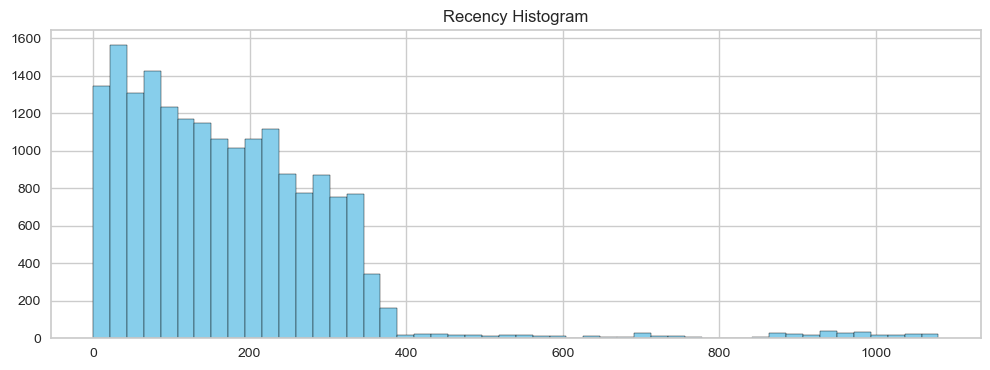

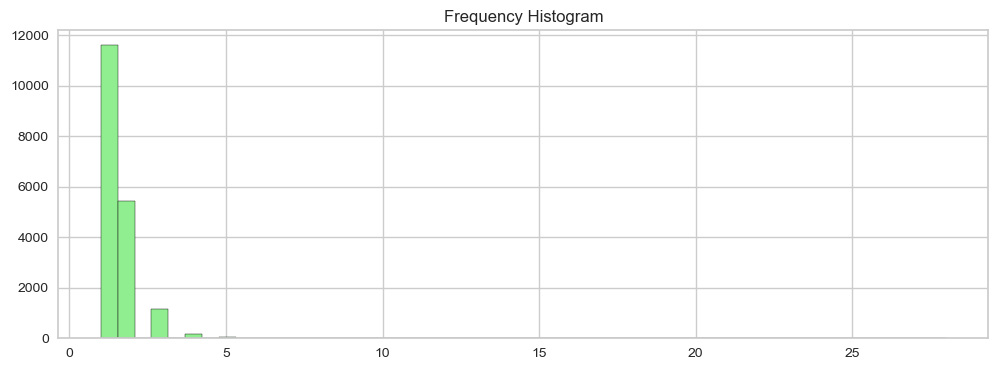

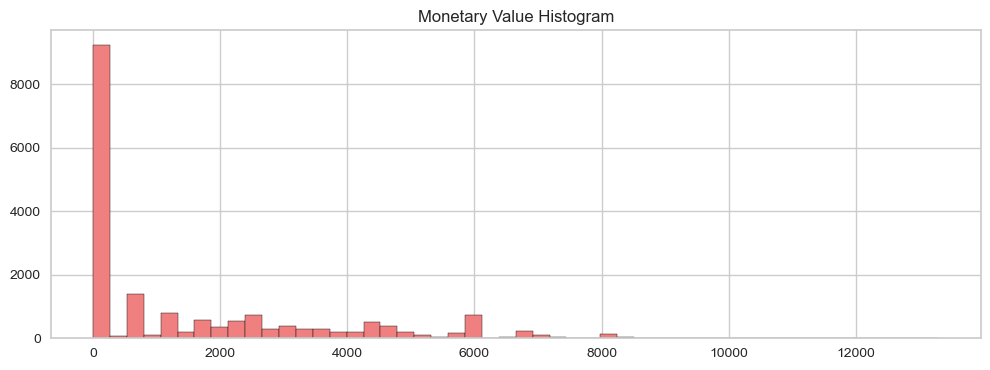

In [33]:
plt.figure(figsize=(12, 4))
plt.hist(rfm['recency'], bins=50, color='skyblue', edgecolor='black')
plt.title('Recency Histogram')
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(rfm['frequency'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Frequency Histogram')
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(rfm['monetary'], bins=50, color='lightcoral', edgecolor='black')
plt.title('Monetary Value Histogram')

plt.show()

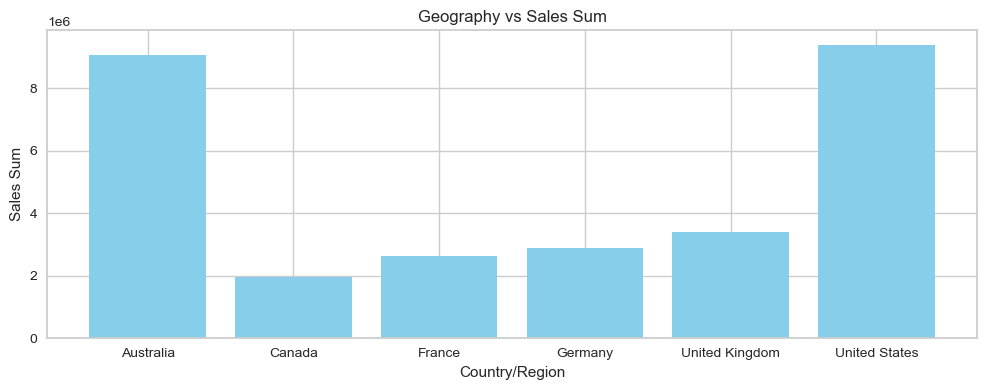

In [34]:
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(12, 4))

plt.bar(sum_geography['country_region'], sum_geography['sum_sales_of_country'].astype(float), color='skyblue')

plt.gca().get_yaxis().set_major_formatter(ScalarFormatter(useOffset=False))

plt.title('Geography vs Sales Sum')
plt.xlabel('Country/Region')
plt.ylabel('Sales Sum')
plt.show()

<AxesSubplot:ylabel='monetary'>

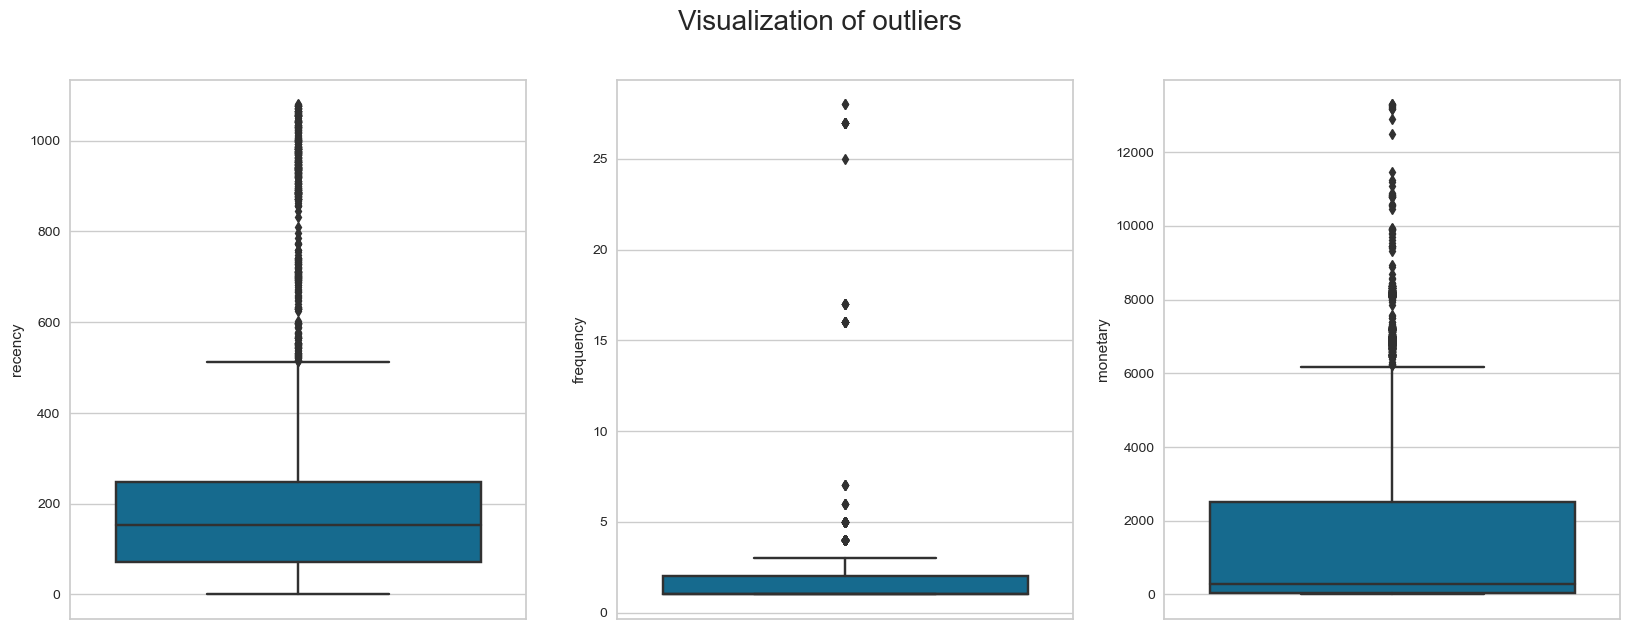

In [35]:
fig = plt.figure(figsize = (20,7))
fig.suptitle("Visualization of outliers",size=20)

axes = fig.add_subplot(1, 3, 1)
sns.boxplot(data=rfm,y="recency")

axes = fig.add_subplot(1, 3, 2)
sns.boxplot(data=rfm,y="frequency")

axes = fig.add_subplot(1, 3, 3)
sns.boxplot(data=rfm,y="monetary")


# 3. Calculate RFM Score

In [293]:
#R score
rfm["r"] = pd.qcut(rfm["recency"],5,labels=[5,4,3,2,1],)

# F score
rfm['f']=pd.qcut(rfm['frequency'].rank(method='first'),5,labels=[1,2,3,4,5])

# M score
rfm["m"] = pd.qcut(rfm["monetary"],5,labels=[1,2,3,4,5])

# RFM Combined Score
rfm["rfm_score"] = rfm["r"].astype(str) +rfm["f"].astype(str) + rfm["m"].astype(str)

rfm.head(20)

,customer_key,recency,frequency,monetary,r,f,m,rfm_score,Segment
0,11000,256,3,8248.99,2,5,5,255,12.0
1,11001,35,3,6383.88,5,5,5,555,15.0
2,11002,325,3,8114.04,1,5,5,155,11.0
3,11003,249,3,8139.29,2,5,5,255,12.0
4,11004,258,3,8196.01,2,5,5,255,12.0
5,11005,257,3,8121.33,2,5,5,255,12.0
6,11006,245,3,8119.03,2,5,5,255,12.0
7,11007,301,3,8211.00,1,5,5,155,11.0
8,11008,318,3,8106.31,1,5,5,155,11.0
9,11009,250,3,8091.33,2,5,5,255,12.0


In [294]:
# RFM Segmentation

rfm_seg = {
     r'1[1-5]1':'Lost',
    r'112':'Lost',
    r'3[2-3]2': 'Almost Lost',
    r'2[3-5]1': 'Almost Lost',
    r'2[2-3][2-3]': 'Almost Lost',
    r'1[2-3]2': 'Almost Lost',
    r'123': 'Almost Lost',
    r'211': 'Almost Lost',
    r'212': 'Almost Lost',
    r'2[4-5][2-5]': 'At risk',
    r'2[2-3][4-5]': 'At risk',
    r'15[2-3]': 'At risk',
    r'14[2-5]': 'At risk',
    r'13[3-5]': 'At risk',
    r'12[4-5]': 'At risk',
    r'[1-2][1-2][4-5]':' Can\'t loose',
    r'15[4-5]': 'Big Spender ',
    r'113': 'Big Spender ',
    r'221': 'About to sleep',
    r'213': 'About to sleep',
    r'3[2-3]1': 'About to sleep',
    r'312': 'About to sleep',
    r'53[4-5]': 'Needs Attention',
    r'[3-4]43': 'Needs Attention',
    r'[3-4]34': 'Needs Attention',
    r'32[4-5]': 'Needs Attention',
    r'52[1-5]': 'Promising',
    r'51[3-5]': 'Promising',
    r'42[4-5]': 'Promising',
    r'[3-4]1[3-5]': 'Promising',
    r'51[1-2]': 'New customers',
    r'4[1-2][1-2]': 'New customers',
    r'311': 'New customers',
    r'[3-5]5[1-3]': 'Potential loyal',
    r'[4-5]4[1-2]': 'Potential loyal ',
    r'[4-5]3[1-3]': 'Potential loyal',
    r'423': 'Potential loyal ',
    r'3[23]3': 'Potential loyal ',
    r'34[1-2]': 'Potential loyal ',
    r'5[4-5][4-5]': 'Champions',
    r'4[4-5]5': 'Champions',
    r'454': 'Champions',
    r'543': 'Loyal customers',
    r'444': 'Loyal customers',
    r'[3-4]35': 'Loyal customers',
    r'3[4-5][4-5]': 'Loyal customers',
}

rfm['Segment'] = rfm['r'].astype(str) + rfm['f'].astype(str)  + rfm['m'].astype(str) 
rfm['Segment'] = rfm['Segment'].replace(rfm_seg, regex=True)
rfm.head(20)

,customer_key,recency,frequency,monetary,r,f,m,rfm_score,Segment
0,11000,256,3,8248.99,2,5,5,255,At risk
1,11001,35,3,6383.88,5,5,5,555,Champions
2,11002,325,3,8114.04,1,5,5,155,Big Spender
3,11003,249,3,8139.29,2,5,5,255,At risk
4,11004,258,3,8196.01,2,5,5,255,At risk
5,11005,257,3,8121.33,2,5,5,255,At risk
6,11006,245,3,8119.03,2,5,5,255,At risk
7,11007,301,3,8211.00,1,5,5,155,Big Spender
8,11008,318,3,8106.31,1,5,5,155,Big Spender
9,11009,250,3,8091.33,2,5,5,255,At risk


# 4. Visualization

In [295]:
# Counting customer in each segment

seg_count = rfm.Segment.value_counts()


In [296]:
# Create DataFrame for visualization

seg_count = pd.DataFrame(data = seg_count)
seg_count = seg_count.reset_index()
seg_count = seg_count.rename(columns={'index':'segment','Segment':'cust_count'})
seg_count.head()

,segment,cust_count
0,At risk,2952
1,Almost Lost,2432
2,Champions,1904
3,Potential loyal,1596
4,Promising,1588


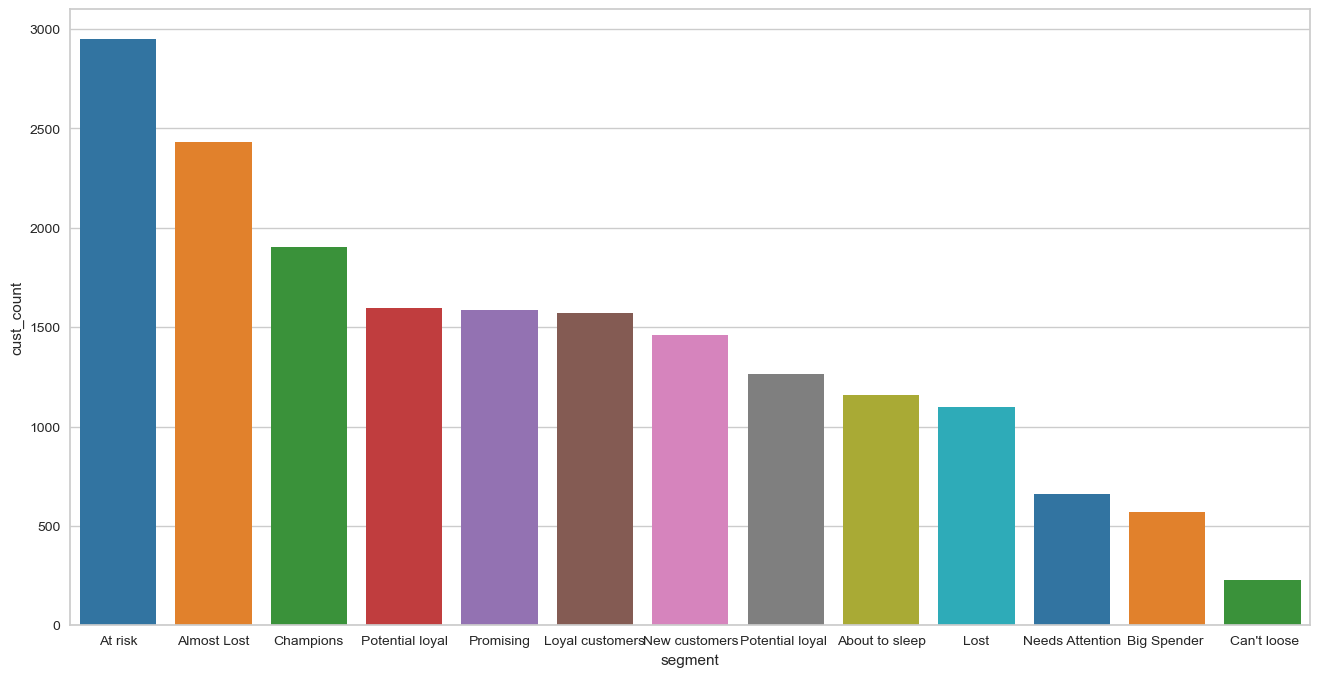

In [297]:
# Bar Chart

palette_color = sns.color_palette("tab10")
plt.figure(figsize = (16,8))
sns.barplot(x = seg_count.segment,y = seg_count.cust_count, palette = palette_color)
plt.show()

In [298]:
# Percentage of each segment 

percentage_dec = seg_count.cust_count / 18484
seg_percentage = round(percentage_dec, 4)
seg_count['percentage'] = seg_percentage * 100
seg_count

,segment,cust_count,percentage
0,At risk,2952,15.97
1,Almost Lost,2432,13.16
2,Champions,1904,10.30
3,Potential loyal,1596,8.63
4,Promising,1588,8.59
5,Loyal customers,1571,8.50
6,New customers,1462,7.91
7,Potential loyal,1263,6.83
8,About to sleep,1158,6.26
9,Lost,1101,5.96


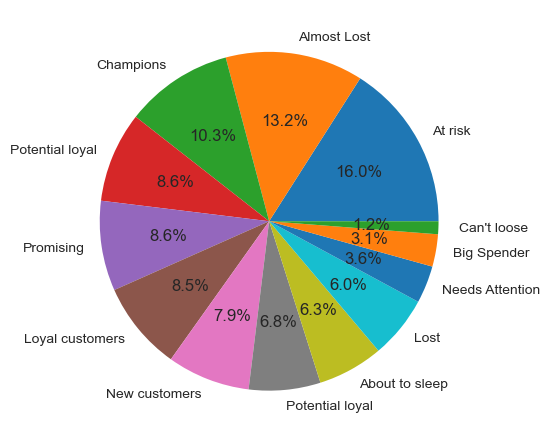

In [299]:
# Pie Chart

palette_color = sns.color_palette("tab10")
plt.pie(seg_count.cust_count, labels = seg_count.segment, colors = palette_color, autopct='%1.1f%%')
plt.show()

In [43]:
# export this rfm segmentation dataset to analyze more in viz tools to analyze more, like:
# why many customer churn, or what make customer champions, etc.

rfm.to_csv("rfm_segmented.csv", index = False)

# 5.Tranformation data of R,F,M

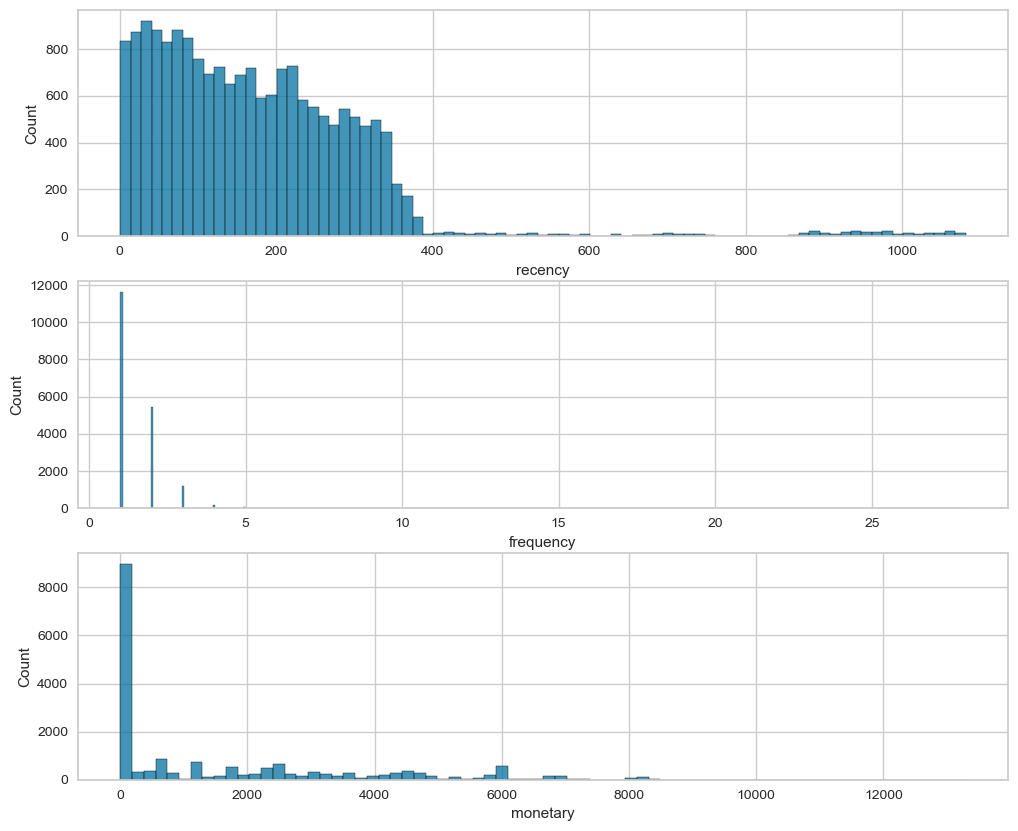

In [58]:
plt.figure(figsize=(12,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.histplot(rfm['recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.histplot(rfm['frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.histplot(rfm['monetary'])

plt.show()

In [45]:
rfm.recency=rfm.recency.apply(lambda x: x+1)

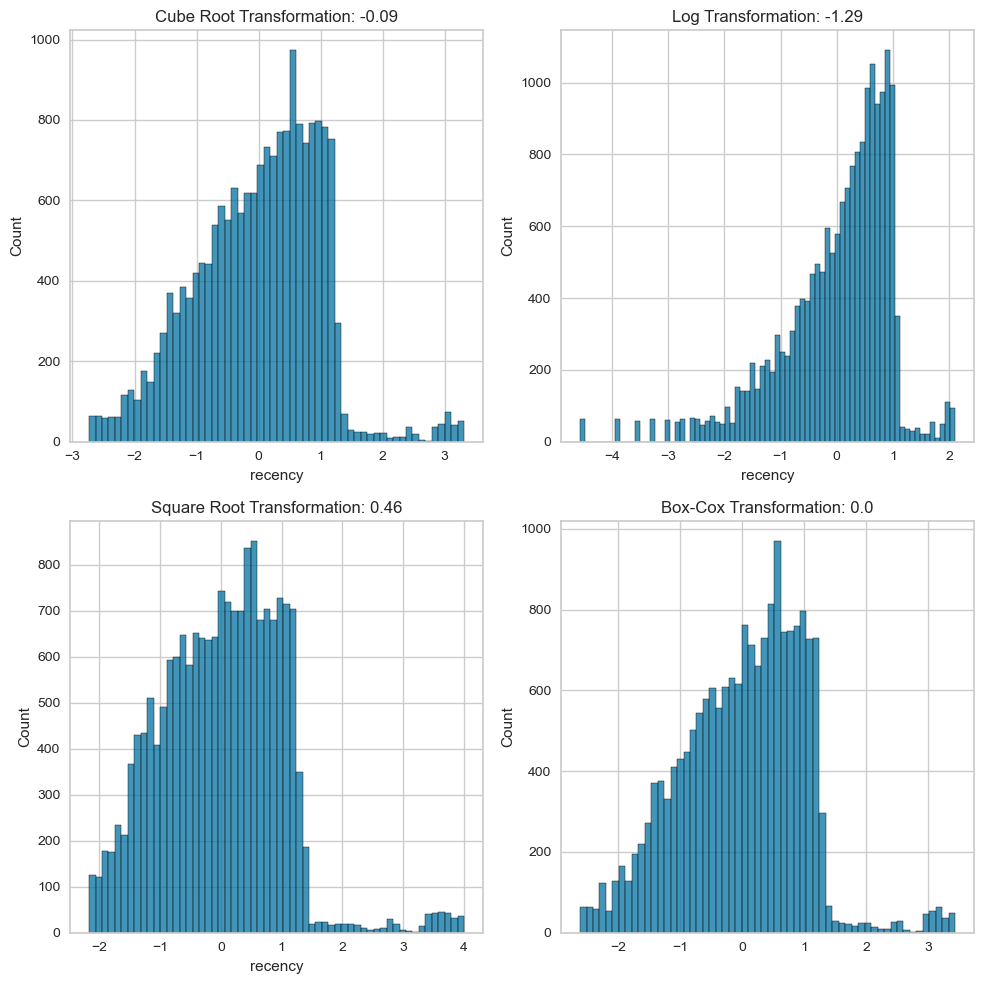

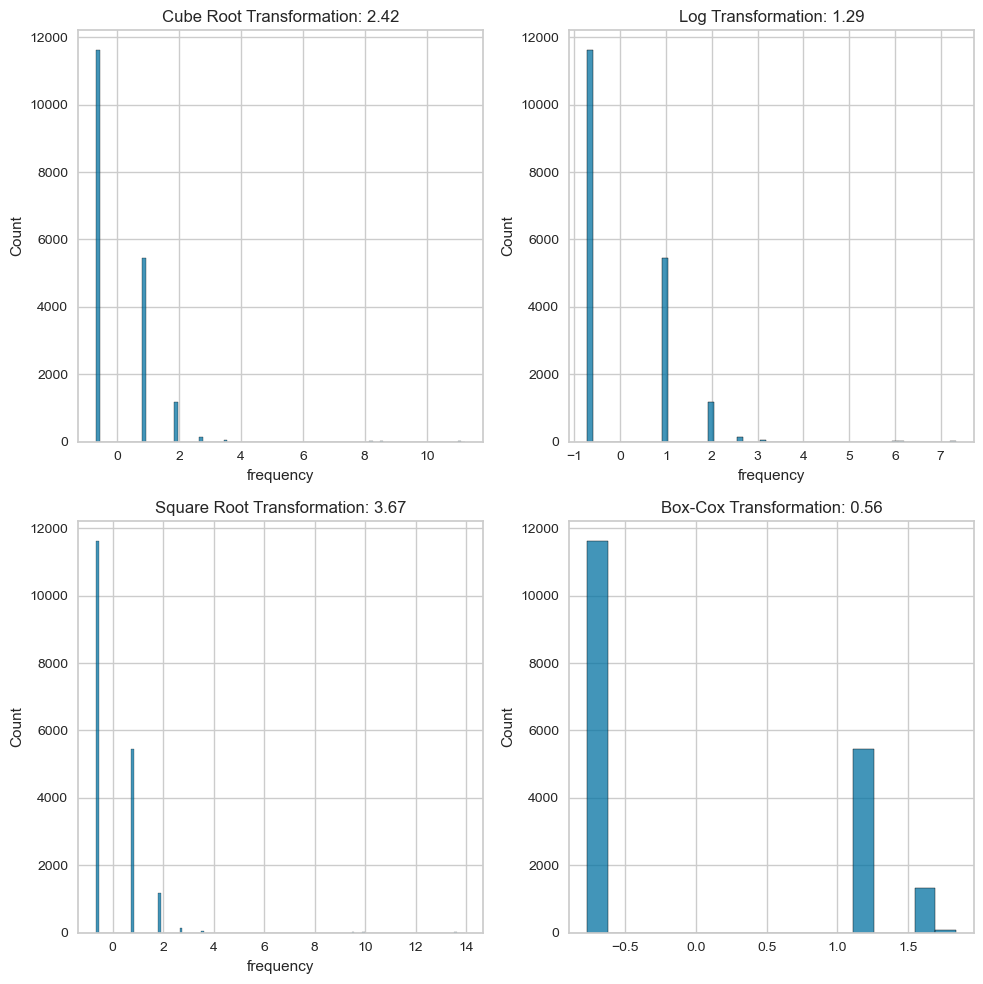

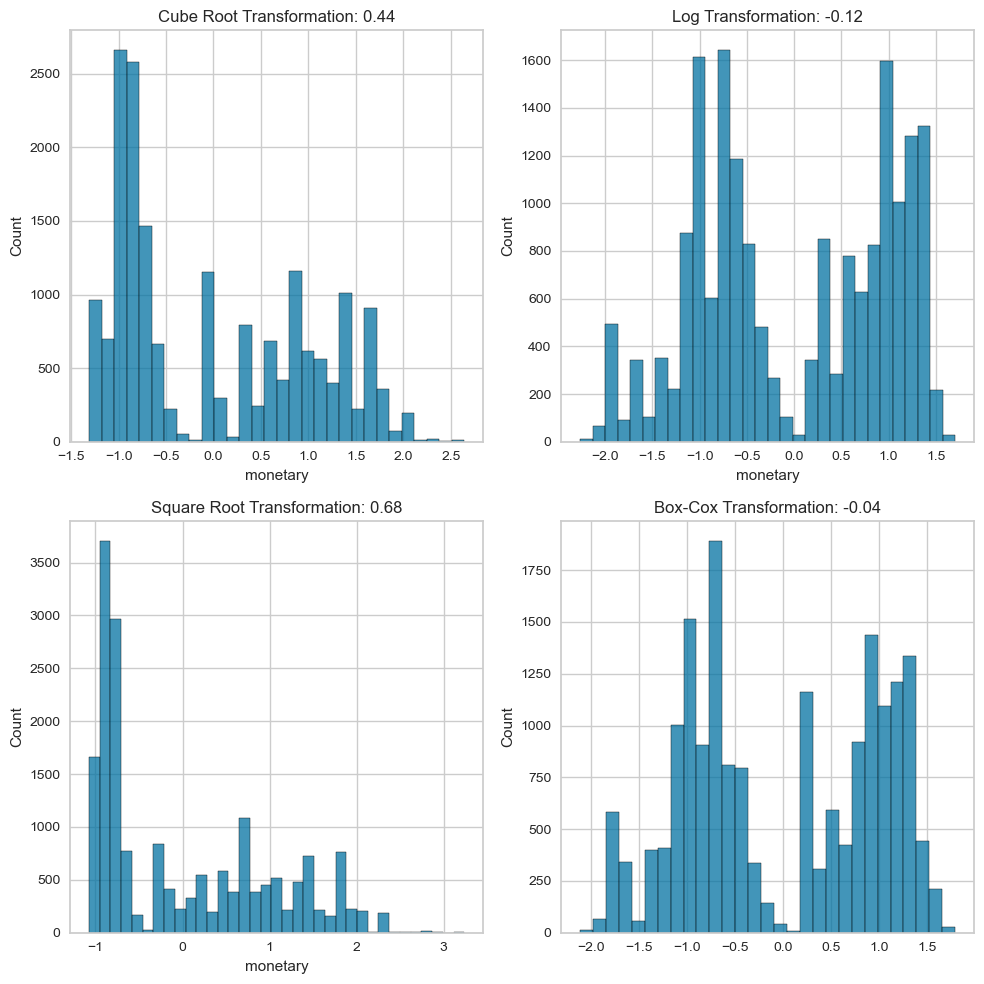

In [183]:

def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    # Cube root transformation
    data_cbrt=np.cbrt(rfm[x])
    z_score_data = (data_cbrt - data_cbrt.mean()) / data_cbrt.std()
    sns.histplot( z_score_data, ax=ax[0, 0])
    ax[0, 0].set_title(f'Cube Root Transformation: {round(data_cbrt.skew(), 2)}')

    # Log transformation
    data_log=np.log(rfm[x])
    z_score_data = (data_log - data_log.mean()) / data_log.std()
    sns.histplot(z_score_data, ax=ax[0, 1])
    ax[0, 1].set_title(f'Log Transformation: {round(data_log.skew(), 2)}')

    # Square root transformation
    data_sqrt=np.sqrt(rfm[x])
    z_score_data = (data_sqrt - data_sqrt.mean()) / data_sqrt.std()
    sns.histplot(z_score_data, ax=ax[1, 0])
    ax[1, 0].set_title(f'Square Root Transformation: {round(data_sqrt.skew(), 2)}')
   
    # Box-Cox transformation (if possible)
    if rfm[x].min() > 0: 
        transformed_data, _ = stats.boxcox(rfm[x])
        z_score_data = (transformed_data - transformed_data.mean()) / transformed_data.std()
        sns.histplot(z_score_data, ax=ax[1, 1])
        ax[1, 1].set_title(f'Box-Cox Transformation: {round(pd.Series(transformed_data).skew(), 2)}')
    else:
        ax[1, 1].set_title('Box-Cox Transformation (Not Applicable)')

    plt.tight_layout()
    plt.show()

analyze_skewness('recency')
analyze_skewness('frequency')
analyze_skewness('monetary')


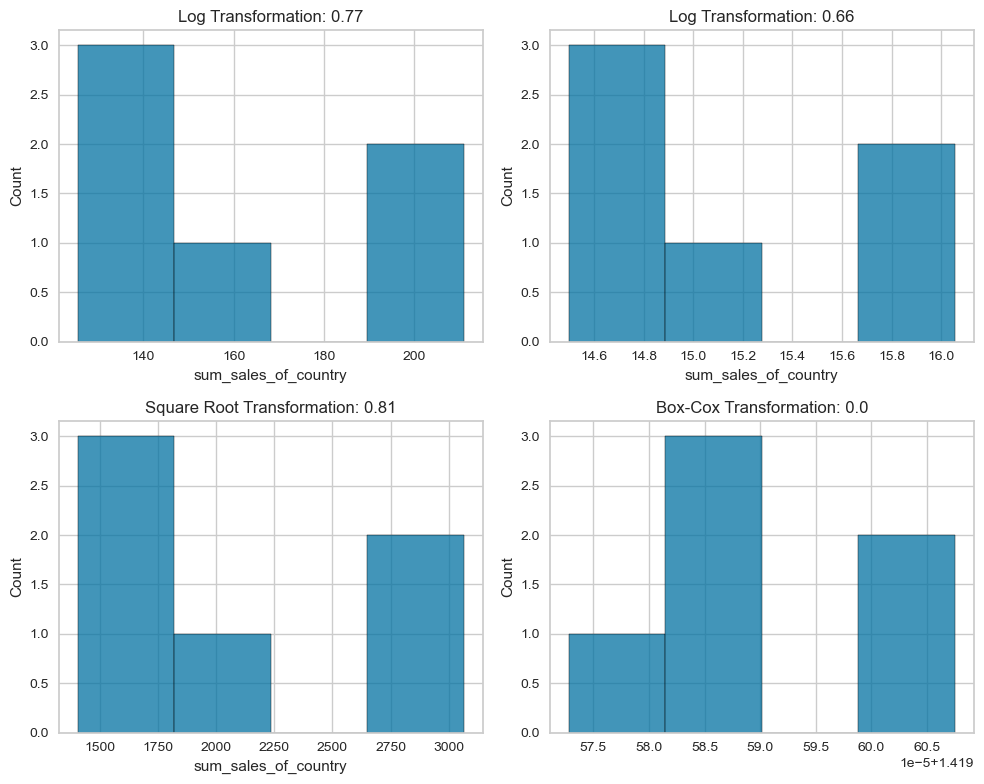

In [47]:

def analyze_skewness_G(x):
    fig, ax = plt.subplots(2, 2, figsize=(10, 8))

    # Cube root transformation
    data_cbrt=np.cbrt(sum_geography[x])
    sns.histplot( data_cbrt, ax=ax[0, 0])
    ax[0, 0].set_title(f'Log Transformation: {round(data_cbrt.skew(), 2)}')

    # Log transformation
    data_log=np.log(sum_geography[x])
    sns.histplot(data_log, ax=ax[0, 1])
    ax[0, 1].set_title(f'Log Transformation: {round(data_log.skew(), 2)}')

    # Square root transformation
    data_sqrt=np.sqrt(sum_geography[x])
    sns.histplot(data_sqrt, ax=ax[1, 0])
    ax[1, 0].set_title(f'Square Root Transformation: {round(data_sqrt.skew(), 2)}')
   
    # Box-Cox transformation (if possible)
    if sum_geography[x].min() > 0:  # Check if the data is positive
        transformed_data, _ = stats.boxcox(sum_geography[x])
        sns.histplot(transformed_data, ax=ax[1, 1])
        ax[1, 1].set_title(f'Box-Cox Transformation: {round(pd.Series(transformed_data).skew(), 2)}')
    else:
        ax[1, 1].set_title('Box-Cox Transformation (Not Applicable)')

    plt.tight_layout()
    plt.show()

analyze_skewness_G('sum_sales_of_country')


In [62]:
rfm_final = pd.DataFrame()
rfm_final['recency'] = stats.boxcox(rfm['recency'])[0]
rfm_final['frequency'] = stats.boxcox(rfm['frequency'])[0]
rfm_final['monetary'] = stats.boxcox(rfm['monetary'])[0]

rfm_final





,recency,frequency,monetary
0,17.861626,0.433569,10.773099
1,7.257971,0.433569,10.412691
2,19.727012,0.433569,10.749799
3,17.655207,0.433569,10.754187
4,17.919941,0.433569,10.763996
...,...,...,...
18479,23.474497,0.000000,8.856791
18480,15.424041,0.000000,9.092583
18481,29.585055,0.000000,9.531660
18482,23.203883,0.000000,8.856791


In [60]:
std_scaler = StandardScaler()
df = rfm_final.copy()
std_scaler.fit(df)
df_scaled = std_scaler.transform(df)
df_scaled = pd.DataFrame(df_scaled, columns = df.columns)
df_scaled

,recency,frequency,monetary
0,0.756776,1.569374,2.025171
1,-1.247763,1.569374,1.732963
2,1.109412,1.569374,2.005606
3,0.717754,1.569374,2.009283
4,0.767800,1.569374,2.017516
...,...,...,...
18479,1.817845,-0.765189,0.699975
18480,0.295969,-0.765189,0.835055
18481,2.972999,-0.765189,1.105894
18482,1.766688,-0.765189,0.699975


# Chapter 4: Kmeans and Silhouette


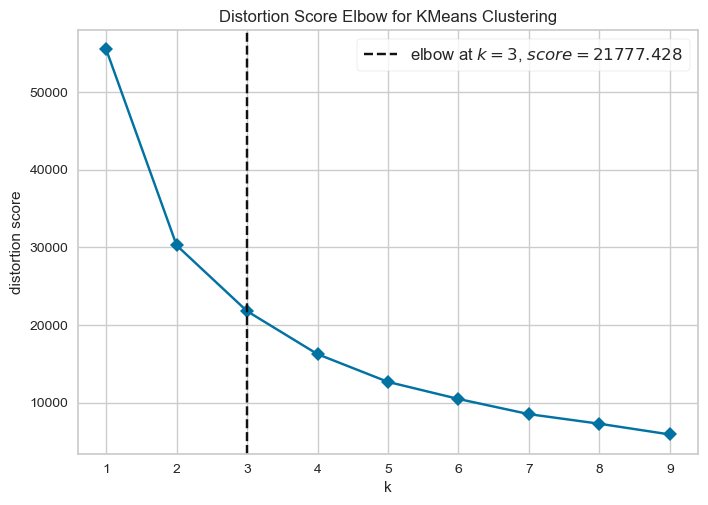

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [49]:
model = KMeans()
visualize = KElbowVisualizer(model, k=(1,10), timings= False)
visualize.fit(df_scaled)        
visualize.show()        

For n_clusters=2, the silhouette score is 0.46789347912429285
For n_clusters=3, the silhouette score is 0.4113167556599272
For n_clusters=4, the silhouette score is 0.43770940326742264
For n_clusters=5, the silhouette score is 0.4575621173961959
For n_clusters=6, the silhouette score is 0.44334616481837347
For n_clusters=7, the silhouette score is 0.46617854891631844
For n_clusters=8, the silhouette score is 0.4747088136062299
For n_clusters=9, the silhouette score is 0.4814710906382236


C:\Users\hkhiy\AppData\Local\Temp\ipykernel_7396\3180706589.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range_n_clusters,silhouette_avg,'bx-', color='blue')


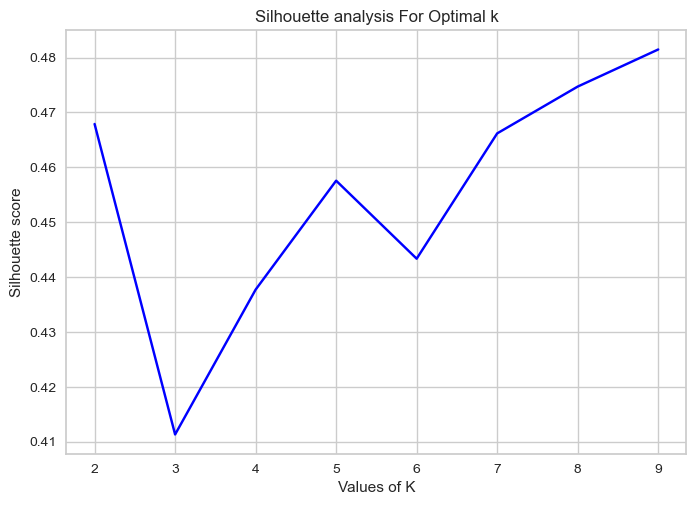

In [50]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
silhouette_avg = []

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    score = silhouette_score(df_scaled, cluster_labels)
    silhouette_avg.append(score)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, score))
plt.plot(range_n_clusters,silhouette_avg,'bx-', color='blue')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

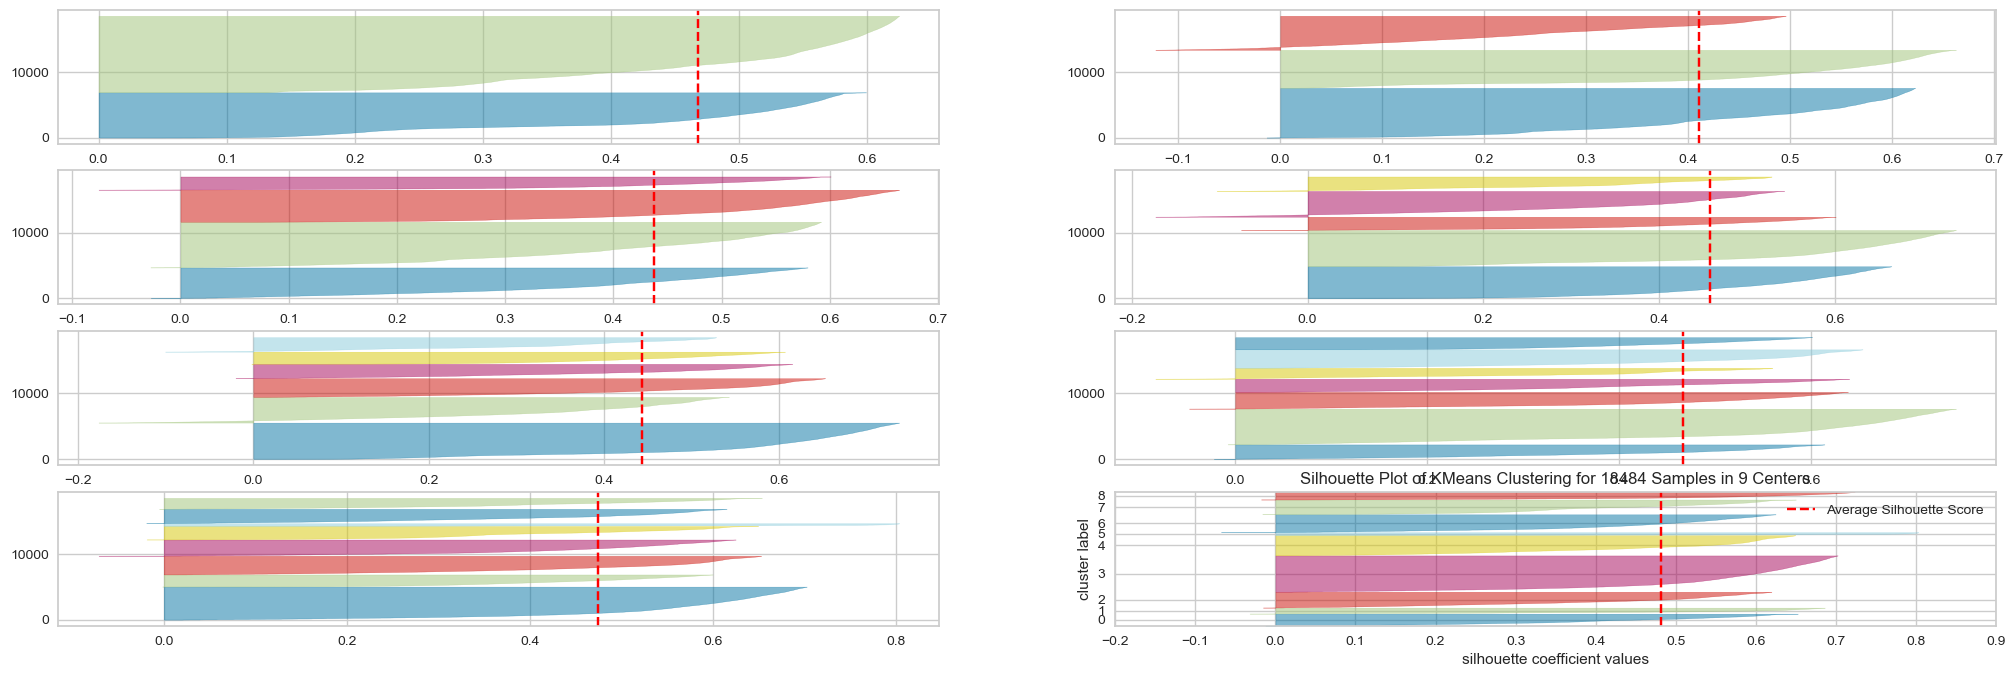

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 18484 Samples in 9 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [51]:
#silhouette
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(4, 2, figsize=(25,8))
for k in [2, 3, 4, 5, 6, 7, 8, 9]:

    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_scaled)

visualizer.show()

In [300]:
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(df_scaled)
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(df_scaled) )
centroid_df

,recency,frequency,monetary
0,0.521259,-0.765189,-0.875907
1,0.001939,1.288715,1.331020
2,-1.035547,-0.765189,-0.413398
3,-0.700418,1.310521,-0.597102
4,1.153508,-0.765189,0.541436


In [301]:
df_new = rfm.assign(cluster = cluster_labels)
df_new.head()


,customer_key,recency,frequency,monetary,r,f,m,rfm_score,Segment,cluster
0,11000,256,3,8248.99,2,5,5,255,At risk,1
1,11001,35,3,6383.88,5,5,5,555,Champions,1
2,11002,325,3,8114.04,1,5,5,155,Big Spender,1
3,11003,249,3,8139.29,2,5,5,255,At risk,1
4,11004,258,3,8196.01,2,5,5,255,At risk,1


In [302]:
df_result = df_new.groupby(['cluster']).agg({
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': ['mean', 'count']
    }).round(2)
df_result

recency frequency monetary      
           mean      mean     mean count
cluster                                 
0        223.31      1.00    87.30  5532
1        162.19      2.22  4555.28  4861
2         55.10      1.00   588.68  3893
3         95.14      2.62   233.28  2004
4        372.90      1.00  1810.99  2194

<AxesSubplot:xlabel='cluster', ylabel='monetary'>

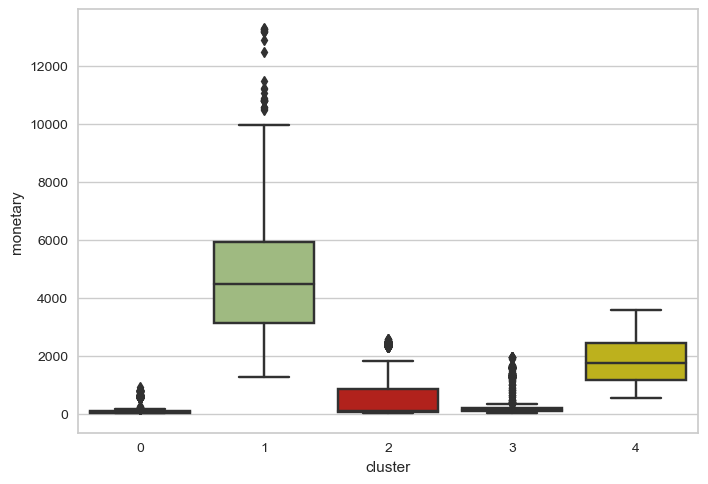

In [303]:
# Box plot to visualize Cluster Id vs Monetary

sns.boxplot(x='cluster', y='monetary', data=df_new)

<AxesSubplot:xlabel='cluster', ylabel='frequency'>

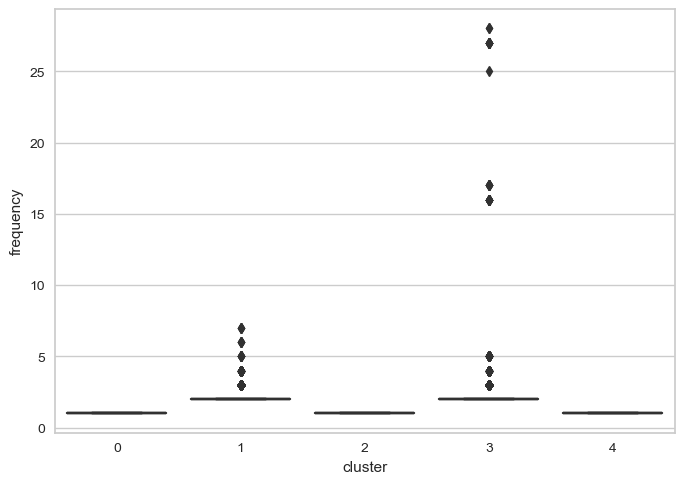

In [304]:
# Box plot to visualize cluster Id vs frequency

sns.boxplot(x='cluster', y='frequency', data=df_new)

<AxesSubplot:xlabel='cluster', ylabel='recency'>

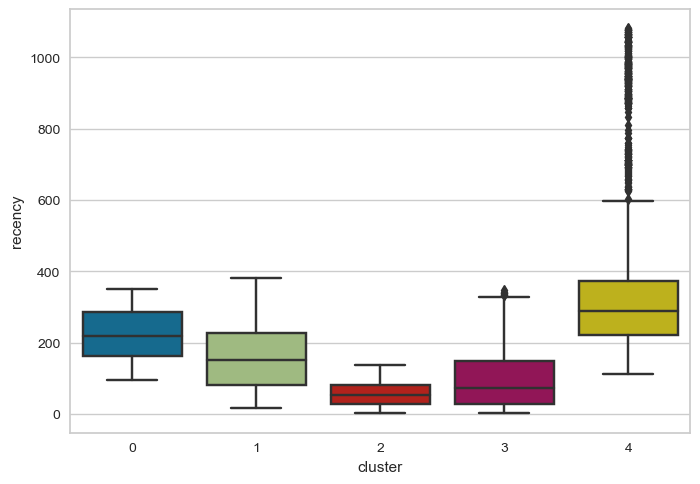

In [305]:
# Box plot to visualize cluster Id vs recency

sns.boxplot(x='cluster', y='recency', data=df_new)

# Caculate CLV

In [306]:
data_CLV=df_result.copy()
data_CLV


recency frequency monetary      
           mean      mean     mean count
cluster                                 
0        223.31      1.00    87.30  5532
1        162.19      2.22  4555.28  4861
2         55.10      1.00   588.68  3893
3         95.14      2.62   233.28  2004
4        372.90      1.00  1810.99  2194

In [307]:

weight_RFM = {
    'WR': 0.7306,
    'WF': 0.1884,
    'WM': 0.0809
}

In [308]:

data_CLV['CLV'] =None
test0= -data_CLV.loc[0, ('recency', 'mean')]*weight_RFM['WR']+ data_CLV.loc[0, ('frequency', 'mean')]*weight_RFM['WF']+data_CLV.loc[0, ('monetary', 'mean')]*weight_RFM['WM']
test1= -data_CLV.loc[1, ('recency', 'mean')]*weight_RFM['WR']+ data_CLV.loc[1, ('frequency', 'mean')]*weight_RFM['WF']+data_CLV.loc[1, ('monetary', 'mean')]*weight_RFM['WM']
test2= -data_CLV.loc[2, ('recency', 'mean')]*weight_RFM['WR']+ data_CLV.loc[2, ('frequency', 'mean')]*weight_RFM['WF']+data_CLV.loc[2, ('monetary', 'mean')]*weight_RFM['WM']
test3= -data_CLV.loc[3, ('recency', 'mean')]*weight_RFM['WR']+ data_CLV.loc[3, ('frequency', 'mean')]*weight_RFM['WF']+data_CLV.loc[3, ('monetary', 'mean')]*weight_RFM['WM']
test4= -data_CLV.loc[4, ('recency', 'mean')]*weight_RFM['WR']+ data_CLV.loc[4, ('frequency', 'mean')]*weight_RFM['WF']+data_CLV.loc[4, ('monetary', 'mean')]*weight_RFM['WM']
data_CLV.loc[0, 'CLV'] = test0
data_CLV.loc[1, 'CLV'] = test1
data_CLV.loc[2, 'CLV'] = test2
data_CLV.loc[3, 'CLV'] = test3
data_CLV.loc[4, 'CLV'] = test4
data_CLV

recency frequency monetary               CLV
           mean      mean     mean count            
cluster                                             
0        223.31      1.00    87.30  5532 -155.899316
1        162.19      2.22  4555.28  4861  250.444386
2         55.10      1.00   588.68  3893    7.556552
3         95.14      2.62   233.28  2004  -50.143324
4        372.90      1.00  1810.99  2194 -125.743249